In [26]:
import numpyro
numpyro.set_platform("gpu")
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import pymc3.sampling_jax

In [27]:
from all_time_elo.tennis_abstract import get_data
pro_df = get_data('/home/martin/data/tennis_atp/')

In [28]:
df = pd.read_csv('/home/martin/projects/all_time_elo/atp_matches_amateur.csv')

/home/martin/miniconda3/envs/pymc3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
slam_names = df['tourney_name'][~df['tourney_name'].str.contains('Davis')].unique()
rel_cols = ['winner_name', 'loser_name', 'tourney_date', 'tourney_name']

In [30]:
# Keep only slams
rel_df = pd.concat([df[df['tourney_name'].isin(slam_names)][rel_cols], 
                    pro_df[pro_df['tourney_name'].isin(slam_names)][rel_cols]])
rel_df = rel_df.dropna(subset=['winner_name', 'loser_name'])

#rel_df = rel_df[(rel_df['tourney_date'].dt.year >= 1900) & (rel_df['tourney_date'].dt.year <= 1920)]

# Find the first tournament and year each player played on:
years = rel_df['tourney_date'].dt.year
rel_df['year']  = years
year_ids = years - years.min()
n_years = len(np.unique(year_ids))

first_seen = dict()

for row, year_id in zip(rel_df.itertuples(), year_ids):
    
    if row.winner_name not in first_seen:
        first_seen[row.winner_name] = [year_id, row.tourney_name]
    
    if row.loser_name not in first_seen:
        first_seen[row.loser_name] = [year_id, row.tourney_name]

In [31]:
# Find number of matches played for each year and tournament (estimate of draw size)
lookup_dict = rel_df.groupby(['tourney_name', 'year']).apply(lambda x: x.shape[0]).to_dict()

In [32]:
# Encode tournaments and players
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
tourney_encoder = LabelEncoder()

encoder.fit(rel_df['winner_name'].values.tolist() + rel_df['loser_name'].values.tolist())
tourney_encoder.fit(rel_df['tourney_name'])

names = encoder.classes_
winner_ids = encoder.transform(rel_df['winner_name'])
loser_ids = encoder.transform(rel_df['loser_name'])
first_seen_ids = np.array([first_seen[x][0] for x in names])
first_seen_tourney_ids = tourney_encoder.transform(np.array([first_seen[x][1] for x in names]))

n_players = len(names)
n_tourneys = len(tourney_encoder.classes_)

n_players

7391

In [10]:
# Put the number of matches per tournament into an array
# Note I'm calling it "draw size" here, which isn't quite right (it's only a proxy).
# So should rename that to number of matches or something perhaps.
draw_size_array = np.zeros((n_tourneys, n_years))
converted_keys = np.array([[tourney_encoder.transform([x[0]])[0],
                   x[1] - years.min()] for x in lookup_dict.keys()])
sizes = list(lookup_dict.values())

draw_size_array[converted_keys[:, 0], converted_keys[:, 1]] = sizes
log_draw_sizes = np.log2(draw_size_array)
mean_log_draw_size = np.mean(log_draw_sizes[log_draw_sizes > -np.inf])

2**(mean_log_draw_size)

83.76914361140727

In [11]:
# For those years with no matches I'm assigning them the mean log draw size
# This is not good. I don't think it ends up being used since no player
# should play their first match at these events since there are no matches.
# Still, there ought to be a better way. Just leaving them at -np.inf doesn't work
# though.
log_draw_sizes[log_draw_sizes < 0] = mean_log_draw_size

In [12]:
with pm.Model() as hierarchical_model:
    mean_chol, _, _ = pm.LKJCholeskyCov(
        "mean_chol", n=n_tourneys, eta=2.0, sd_dist=pm.HalfNormal.dist(1.0), compute_corr=True
    )
    
    prior_means = pm.MvGaussianRandomWalk('prior_means', chol=mean_chol, shape=(n_years-1, n_tourneys))
    full_prior_means = pm.math.concatenate([np.zeros((1, n_tourneys)), prior_means], axis=0)
    
    draw_size_mean_factor = pm.Normal('mean_draw_size_factor', mu=0., sigma=1.)
    
    full_prior_means = full_prior_means + draw_size_mean_factor * (log_draw_sizes.T - mean_log_draw_size)
    
    init_sd = pm.HalfNormal('init_sd', 1., shape=(1, n_tourneys))
    
    draw_size_sd_factor = pm.Normal('sd_draw_size_factor', mu=0., sigma=1.)
    
    sd_chol, _, _ = pm.LKJCholeskyCov(
        "sd_chol", n=n_tourneys, eta=2.0, sd_dist=pm.HalfNormal.dist(1.0), compute_corr=True
    )
    
    prior_log_sds = pm.MvGaussianRandomWalk('prior_log_sds', chol=sd_chol, shape=(n_years-1, n_tourneys))
    full_prior_log_sds = pm.math.concatenate([pm.math.log(init_sd), prior_log_sds], axis=0)
    full_prior_log_sds = full_prior_log_sds + draw_size_sd_factor * (log_draw_sizes.T - mean_log_draw_size)
    full_prior_sds = pm.math.exp(full_prior_log_sds)
        
    player_skills = pm.Normal('player_skills', 
                              mu=full_prior_means[first_seen_ids, first_seen_tourney_ids], 
                              sigma=full_prior_sds[first_seen_ids, first_seen_tourney_ids], shape=n_players)

    logit_skills = player_skills[winner_ids] - player_skills[loser_ids]
    
    # Data likelihood
    lik = pm.Bernoulli('win_lik', logit_p=logit_skills, observed=np.ones(winner_ids.shape[0]))

In [13]:
from pymc3.sampling_jax import sample_numpyro_nuts

In [14]:
import arviz as az

In [15]:
#%%time
#with hierarchical_model:
#    hierarchical_trace = sample_numpyro_nuts(draws=1000, tune=1000)

hierarchical_trace = az.from_netcdf('./trace_1k_full_draw_size.netcdf')

In [17]:
hierarchical_trace

Inference data with groups:
	> posterior

In [18]:
hierarchical_trace.posterior['mean_draw_size_factor'].mean()

<xarray.DataArray 'mean_draw_size_factor' ()>
array(-0.40290845)

In [19]:
hierarchical_trace.posterior['sd_draw_size_factor'].mean()

<xarray.DataArray 'sd_draw_size_factor' ()>
array(0.09340042)

In [59]:
year_x = np.arange(years.min() + 1, years.max() + 1)

t_priors = pd.DataFrame(
            hierarchical_trace.posterior['prior_means'].values.mean(axis=(0, 1)),
             index=year_x, columns=tourney_encoder.classes_)

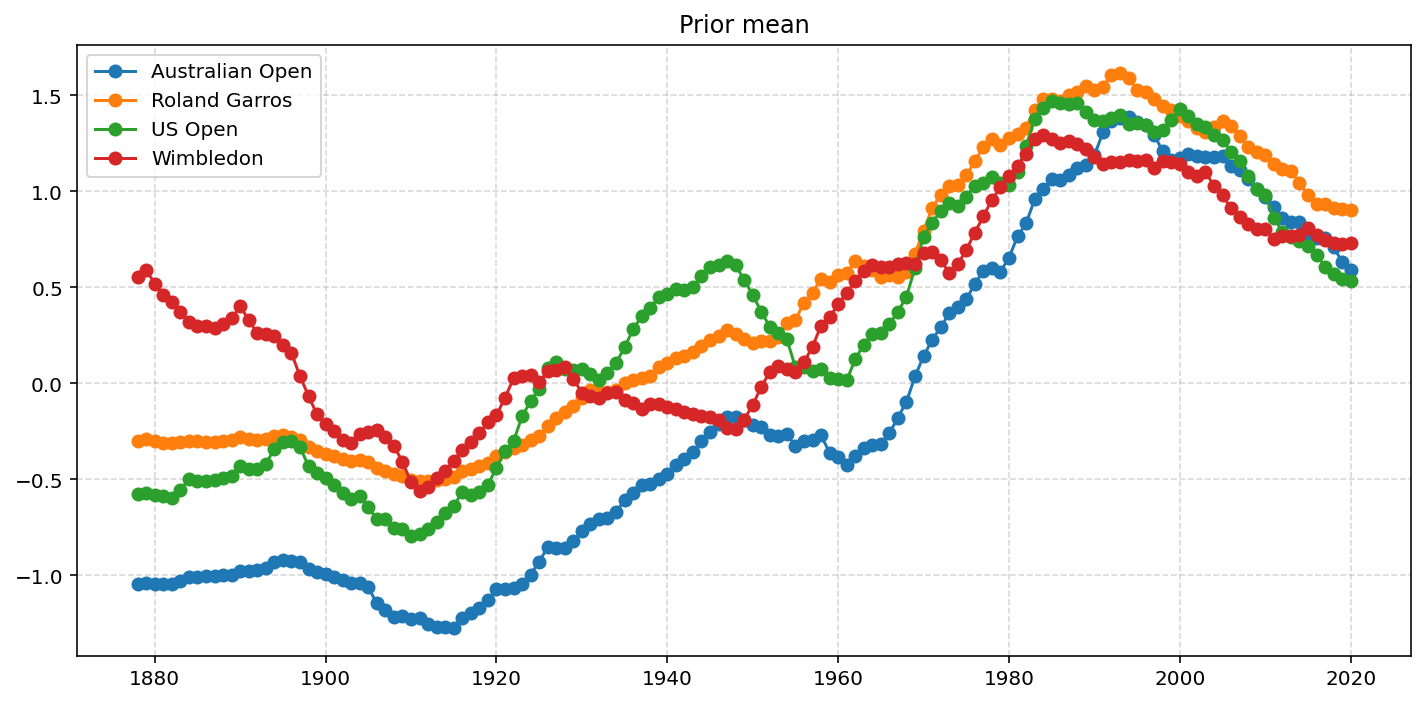

In [60]:
f, ax = plt.subplots(1, 1)

t_priors.plot(marker='o', ax=ax)

ax.set_title('Prior mean')
f.set_size_inches(10, 5)
f.tight_layout()
plt.grid(alpha=0.5, linestyle='--')
plt.savefig('prior_mean_with_draw_size.png', dpi=300)

In [63]:
year_x = np.arange(years.min(), years.max() + 1)
init_sds = hierarchical_trace.posterior['init_sd_log__'].mean(axis=(0, 1)).values
t_prior_sds = pd.DataFrame(np.concatenate([
    np.exp(init_sds),
    np.exp(hierarchical_trace.posterior['prior_log_sds'].values).mean(axis=(0, 1)),
    ]),
                           index=year_x, columns=tourney_encoder.classes_)

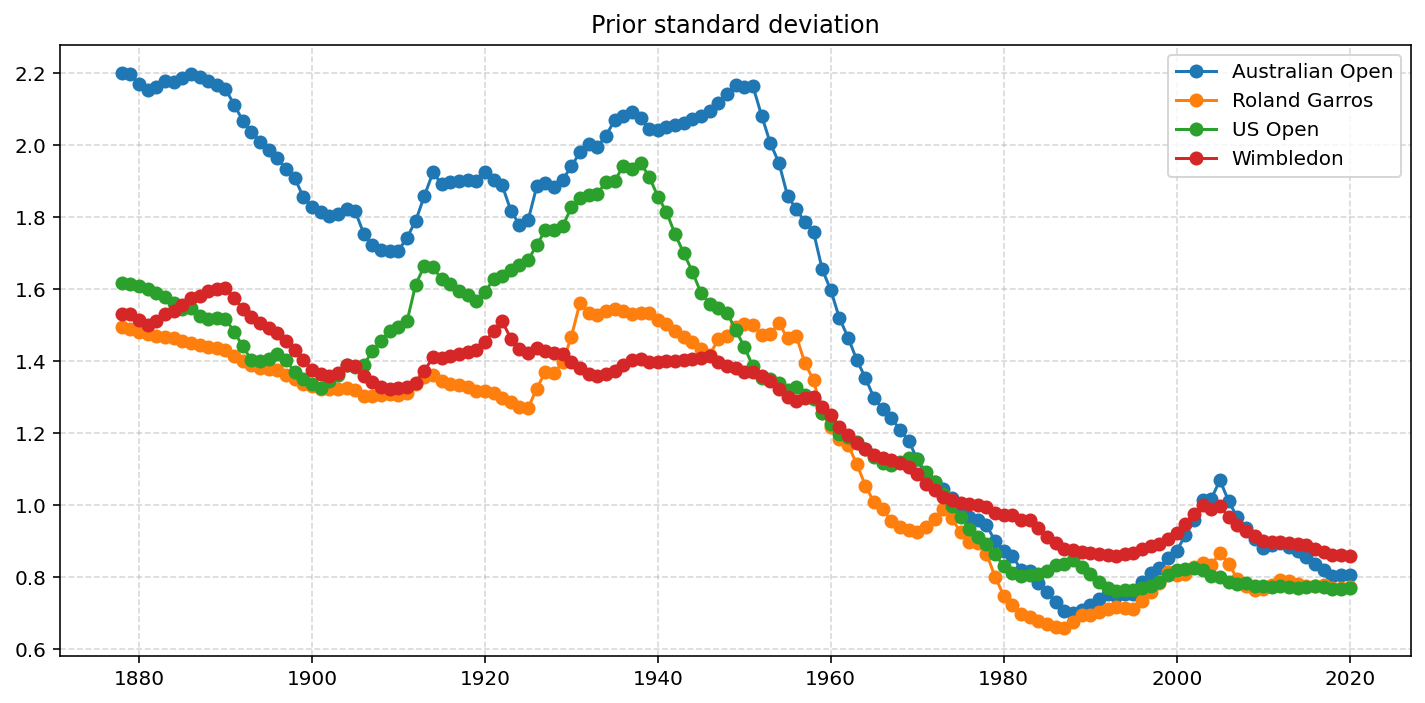

In [78]:
f, ax = plt.subplots(1, 1)

t_prior_sds.iloc[1:].plot(marker='o', ax=ax)

ax.set_title('Prior standard deviation')
#ax.axvline(1951)
f.set_size_inches(10, 5)
f.tight_layout()
plt.grid(alpha=0.5, linestyle='--', which='major')

plt.savefig('prior_sd_with_draw_size.png', dpi=300)

array([[<AxesSubplot:title={'center':'sd_draw_size_factor'}>,
        <AxesSubplot:title={'center':'sd_draw_size_factor'}>]],
      dtype=object)

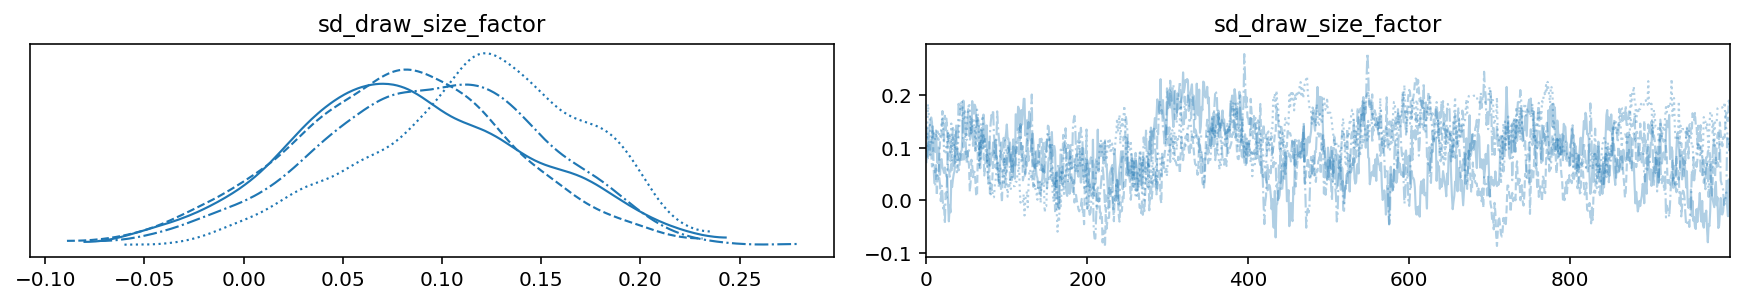

In [35]:
az.plot_trace(hierarchical_trace, var_names='sd_draw_size_factor', compact=True)

In [21]:
rhats = az.rhat(hierarchical_trace)

In [25]:
pd.Series({x: np.round(np.max(y).values, 2) for x, y in rhats.items()})

mean_chol_cholesky-cov-packed__    1.04
prior_means                        2.14
mean_draw_size_factor              1.05
init_sd_log__                      1.13
sd_draw_size_factor                1.07
sd_chol_cholesky-cov-packed__      1.10
prior_log_sds                      1.08
player_skills                      1.99
dtype: float64

In [38]:
hierarchical_trace.to_netcdf('./trace_1k_full_draw_size.netcdf')

'./trace_1k_full_draw_size.netcdf'

In [39]:
player_means = hierarchical_trace.to_dict()['posterior']['player_skills'].mean(axis=(0, 1))
player_sds = hierarchical_trace.to_dict()['posterior']['player_skills'].std(axis=(0, 1))

In [40]:
player_mean_series = pd.Series(player_means, index=encoder.classes_)
player_sd_series = pd.Series(player_sds, index=encoder.classes_)

In [41]:
player_results = pd.concat([player_mean_series, player_sd_series], axis=1, keys=['mean', 'sd'])

In [42]:
player_results.sort_values(by='mean', ascending=False).round(3).head(25)

,mean,sd
Don Budge,5.178,0.644
Bobby Riggs,4.882,0.691
Bill Tilden Ii,4.877,0.542
Frederick Ted Schroeder,4.839,0.715
Jack Kramer,4.769,0.659
Jean Rene Lacoste,4.719,0.553
Joe Hunt,4.655,0.729
Bill Johnston,4.590,0.582
Henri Jean Cochet,4.537,0.543
Novak Djokovic,4.517,0.526


In [43]:
t_prior_sds

,Australian Open,Roland Garros,US Open,Wimbledon
1878,2.200871,1.494360,1.615897,1.530820
1879,2.197386,1.488976,1.614147,1.531684
1880,2.168975,1.481560,1.607618,1.513599
1881,2.152945,1.474115,1.600646,1.500297
1882,2.160966,1.469338,1.588868,1.509886
...,...,...,...,...
2016,0.836344,0.774788,0.776030,0.878831
2017,0.820534,0.778337,0.772367,0.868843
2018,0.803485,0.769748,0.767488,0.860495
2019,0.804370,0.770923,0.767150,0.859885


In [77]:
# Z score relative to their prior -- how much better were they than predicted?
player_zs = pd.Series(player_means / t_prior_sds.values[first_seen_ids, first_seen_tourney_ids],
                      index=encoder.classes_)

player_zs.sort_values(ascending=False).head(50)

Roger Federer            5.197215
Pete Sampras             4.534199
Bjorn Borg               4.475917
Rafael Nadal             4.442173
Ivan Lendl               4.428359
Andre Agassi             4.329150
Novak Djokovic           4.225967
Michael Stich            4.165615
John McEnroe             4.155803
Yevgeny Kafelnikov       4.071181
Thomas Muster            3.915056
Jim Courier              3.908846
Juan Martin del Potro    3.881963
Andy Roddick             3.863198
Kei Nishikori            3.830371
Boris Becker             3.826942
Patrick Rafter           3.803787
Andy Murray              3.742153
Marat Safin              3.719170
Jo-Wilfried Tsonga       3.699318
Richard Krajicek         3.677824
Stefan Edberg            3.663332
Milos Raonic             3.644119
Mats Wilander            3.598710
Sergi Bruguera           3.591902
Lleyton Hewitt           3.587172
Tomas Berdych            3.584945
Stan Wawrinka            3.551422
Marcelo Rios             3.529933
Aaron Krickste

<AxesSubplot:xlabel='year'>

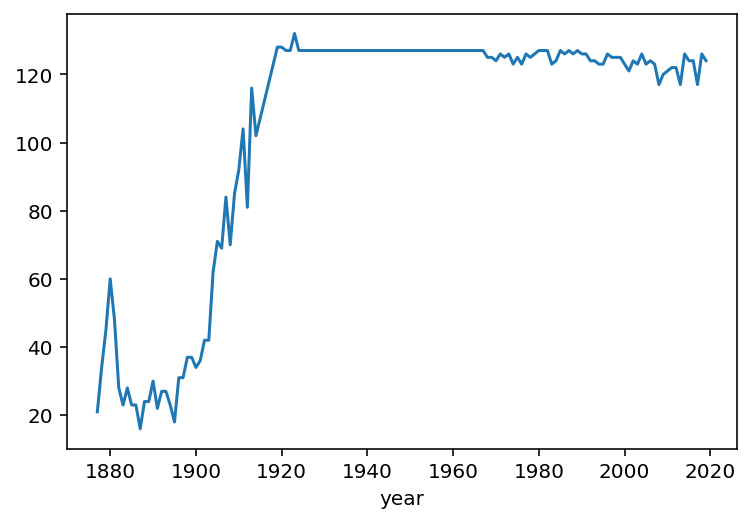

In [31]:
rel_df['year'] = rel_df['tourney_date'].dt.year

rel_df[rel_df['tourney_name'].str.contains('Wimbledon')].groupby('year').apply(lambda x: x.shape[0]).plot()

In [32]:
rel_df[rel_df['tourney_name'].str.contains('US')].groupby('year').apply(lambda x: x.shape[0]).sort_values().tail(20)

year
1919    127
1952    127
1986    127
1957    127
1958    127
1956    127
1960    127
1962    127
1963    127
1964    127
1966    127
1967    127
1959    127
1914    137
1908    145
1913    147
1912    158
1909    164
1910    181
1911    201
dtype: int64